In [ ]:
from __future__ import print_function, division  # requires Python >= 2.6
import numpy as np
from scipy.sparse import kron, identity
from scipy.sparse.linalg import eigsh  # Lanczos routine from ARPACK
from collections import namedtuple
import time
import matplotlib.pyplot as plt

Block = namedtuple("Block", ["length", "basis_size", "operator_dict"])
EnlargedBlock = namedtuple("EnlargedBlock", ["length", "basis_size", "operator_dict"])

In [ ]:
def is_valid_block(block):
    for op in block.operator_dict.values():
        if op.shape[0] != block.basis_size or op.shape[1] != block.basis_size:
            return False
    return True

is_valid_enlarged_block = is_valid_block

# Model-specific code for the Heisenberg XXZ chain
model_d = 2  # single-site basis size

Sz1 = np.array([[0.5, 0], [0, -0.5]], dtype='d')  # single-site S^z
Sp1 = np.array([[0, 1], [0, 0]], dtype='d')  # single-site S^+

H1 = np.array([[0, 0], [0, 0]], dtype='d')  # single-site portion of H is zero

In [ ]:
def H2(Sz1, Sp1, Sz2, Sp2):  # two-site part of H
    """Given the operators S^z and S^+ on two sites in different Hilbert spaces
    (e.g. two blocks), returns a Kronecker product representing the
    corresponding two-site term in the Hamiltonian that joins the two sites.
    """
    J = Jz = 1.
    return (
        (J / 2) * (kron(Sp1, Sp2.conjugate().transpose()) + kron(Sp1.conjugate().transpose(), Sp2)) +
        Jz * kron(Sz1, Sz2)
    )

# conn refers to the connection operator, that is, the operator on the edge of
# the block, on the interior of the chain.  We need to be able to represent S^z
# and S^+ on that site in the current basis in order to grow the chain.
initial_block = Block(length=1, basis_size=model_d, operator_dict={
    "H": H1,
    "conn_Sz": Sz1,
    "conn_Sp": Sp1,
})

In [ ]:
def enlarge_block(block):
    """This function enlarges the provided Block by a single site, returning an
    EnlargedBlock.
    """
    mblock = block.basis_size
    o = block.operator_dict

    # Create the new operators for the enlarged block.  Our basis becomes a
    # Kronecker product of the Block basis and the single-site basis.  NOTE:
    # `kron` uses the tensor product convention making blocks of the second
    # array scaled by the first.  As such, we adopt this convention for
    # Kronecker products throughout the code.
    enlarged_operator_dict = {
        "H": kron(o["H"], identity(model_d)) + kron(identity(mblock), H1) + H2(o["conn_Sz"], o["conn_Sp"], Sz1, Sp1),
        "conn_Sz": kron(identity(mblock), Sz1),
        "conn_Sp": kron(identity(mblock), Sp1),
    }

    return EnlargedBlock(length=(block.length + 1),
                         basis_size=(block.basis_size * model_d),
                         operator_dict=enlarged_operator_dict)

In [ ]:
def rotate_and_truncate(operator, transformation_matrix):
    """Transforms the operator to the new (possibly truncated) basis given by
    `transformation_matrix`.
    """
    return transformation_matrix.conjugate().transpose().dot(operator.dot(transformation_matrix))

In [ ]:
def single_dmrg_step(sys, env, m):
    """Performs a single DMRG step using `sys` as the system and `env` as the
    environment, keeping a maximum of `m` states in the new basis.
    """
    assert is_valid_block(sys)
    assert is_valid_block(env)

    # Enlarge each block by a single site.
    sys_enl = enlarge_block(sys)
    if sys is env:  # no need to recalculate a second time
        env_enl = sys_enl
    else:
        env_enl = enlarge_block(env)

    assert is_valid_enlarged_block(sys_enl)
    assert is_valid_enlarged_block(env_enl)

    # Construct the full superblock Hamiltonian.
    m_sys_enl = sys_enl.basis_size
    m_env_enl = env_enl.basis_size
    sys_enl_op = sys_enl.operator_dict
    env_enl_op = env_enl.operator_dict
    superblock_hamiltonian = kron(sys_enl_op["H"], identity(m_env_enl)) + kron(identity(m_sys_enl), env_enl_op["H"]) + \
                             H2(sys_enl_op["conn_Sz"], sys_enl_op["conn_Sp"], env_enl_op["conn_Sz"], env_enl_op["conn_Sp"])

    # Call ARPACK to find the superblock ground state.  ("SA" means find the
    # "smallest in amplitude" eigenvalue.)
    (energy,), psi0 = eigsh(superblock_hamiltonian, k=1, which="SA")

    # Construct the reduced density matrix of the system by tracing out the
    # environment
    #
    # We want to make the (sys, env) indices correspond to (row, column) of a
    # matrix, respectively.  Since the environment (column) index updates most
    # quickly in our Kronecker product structure, psi0 is thus row-major ("C
    # style").
    psi0 = psi0.reshape([sys_enl.basis_size, -1], order="C")
    rho = np.dot(psi0, psi0.conjugate().transpose())

    # Diagonalize the reduced density matrix and sort the eigenvectors by
    # eigenvalue.
    evals, evecs = np.linalg.eigh(rho)
    possible_eigenstates = []
    for eval, evec in zip(evals, evecs.transpose()):
        possible_eigenstates.append((eval, evec))
    possible_eigenstates.sort(reverse=True, key=lambda x: x[0])  # largest eigenvalue first

    # Build the transformation matrix from the `m` overall most significant
    # eigenvectors.
    my_m = min(len(possible_eigenstates), m)
    transformation_matrix = np.zeros((sys_enl.basis_size, my_m), dtype='d', order='F')
    for i, (eval, evec) in enumerate(possible_eigenstates[:my_m]):
        transformation_matrix[:, i] = evec

    truncation_error = 1 - sum([x[0] for x in possible_eigenstates[:my_m]])
    #print("truncation error:", truncation_error)

    # Rotate and truncate each operator.
    new_operator_dict = {}
    for name, op in sys_enl.operator_dict.items():
        new_operator_dict[name] = rotate_and_truncate(op, transformation_matrix)

    newblock = Block(length=sys_enl.length,
                     basis_size=my_m,
                     operator_dict=new_operator_dict)

    return newblock, energy

In [ ]:
def infinite_system_algorithm(L, m):
    block = initial_block
    # Repeatedly enlarge the system by performing a single DMRG step, using a
    # reflection of the current block as the environment.
    print("L = ", end='')
    while 2 * block.length < L:
        print(block.length * 2 + 2, end=' ')
        block, energy = single_dmrg_step(block, block, m=m)
        #print("E/L =", energy / (block.length * 2))
    return block

In [ ]:
np.set_printoptions(precision=10, suppress=True, threshold=10000, linewidth=300)

tm=time.time()
block=infinite_system_algorithm(L=100, m=20)
print(time.time()-tm)

L = 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 100 3.450639009475708


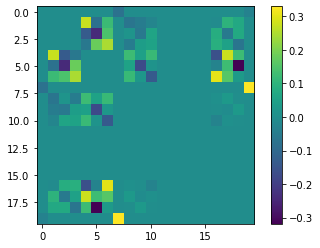

In [ ]:
Ham=block.operator_dict['H']
plt.imshow(Ham - Ham*np.eye(20))
plt.colorbar()

In [ ]:
def graphic(sys_block, env_block, sys_label="l"):
    """Returns a graphical representation of the DMRG step we are about to
    perform, using '=' to represent the system sites, '-' to represent the
    environment sites, and '**' to represent the two intermediate sites.
    """
    assert sys_label in ("l", "r")
    graphic = ("=" * sys_block.length) + "**" + ("-" * env_block.length)
    if sys_label == "r":
        # The system should be on the right and the environment should be on
        # the left, so reverse the graphic.
        graphic = graphic[::-1]
    return graphic

In [ ]:
def finite_system_algorithm(L, m_warmup, m_sweep_list):
    assert L % 2 == 0  # require that L is an even number

    # To keep things simple, this dictionary is not actually saved to disk, but
    # we use it to represent persistent storage.
    block_disk = {}  # "disk" storage for Block objects

    # Use the infinite system algorithm to build up to desired size.  Each time
    # we construct a block, we save it for future reference as both a left
    # ("l") and right ("r") block, as the infinite system algorithm assumes the
    # environment is a mirror image of the system.
    block = initial_block
    block_disk["l", block.length] = block
    block_disk["r", block.length] = block
    while 2 * block.length < L:
        # Perform a single DMRG step and save the new Block to "disk"
        print(graphic(block, block))
        block, energy = single_dmrg_step(block, block, m=m_warmup)
        print("E/L =", energy / (block.length * 2))
        block_disk["l", block.length] = block
        block_disk["r", block.length] = block

    # Now that the system is built up to its full size, we perform sweeps using
    # the finite system algorithm.  At first the left block will act as the
    # system, growing at the expense of the right block (the environment), but
    # once we come to the end of the chain these roles will be reversed.
    sys_label, env_label = "l", "r"
    sys_block = block; del block  # rename the variable
    for m in m_sweep_list:
        while True:
            # Load the appropriate environment block from "disk"
            env_block = block_disk[env_label, L - sys_block.length - 2]
            if env_block.length == 1:
                # We've come to the end of the chain, so we reverse course.
                sys_block, env_block = env_block, sys_block
                sys_label, env_label = env_label, sys_label

            # Perform a single DMRG step.
            print(graphic(sys_block, env_block, sys_label))
            sys_block, energy = single_dmrg_step(sys_block, env_block, m=m)

            print("E/L =", energy / L)

            # Save the block from this step to disk.
            block_disk[sys_label, sys_block.length] = sys_block

            # Check whether we just completed a full sweep.
            if sys_label == "l" and 2 * sys_block.length == L:
                break  # escape from the "while True" loop


In [ ]:
finite_system_algorithm(L=20, m_warmup=10, m_sweep_list=[10, 20, 30, 40, 40])

In [ ]:
def index_map(array):
    """Given an array, returns a dictionary that allows quick access to the
    indices at which a given value occurs.

    Example usage:

    >>> by_index = index_map([3, 5, 5, 7, 3])
    >>> by_index[3]
    [0, 4]
    >>> by_index[5]
    [1, 2]
    >>> by_index[7]
    [3]
    """
    d = {}
    for index, value in enumerate(array):
        d.setdefault(value, []).append(index)
    return d


def single_dmrg_step(sys, env, m, target_Sz, psi0_guess=None):
    """Performs a single DMRG step using `sys` as the system and `env` as the
    environment, keeping a maximum of `m` states in the new basis.  If
    `psi0_guess` is provided, it will be used as a starting vector for the
    Lanczos algorithm.
    """
    assert is_valid_block(sys)
    assert is_valid_block(env)

    # Enlarge each block by a single site.
    sys_enl = enlarge_block(sys)
    sys_enl_basis_by_sector = index_map(sys_enl.basis_sector_array)
    if sys is env:  # no need to recalculate a second time
        env_enl = sys_enl
        env_enl_basis_by_sector = sys_enl_basis_by_sector
    else:
        env_enl = enlarge_block(env)
        env_enl_basis_by_sector = index_map(env_enl.basis_sector_array)

    assert is_valid_enlarged_block(sys_enl)
    assert is_valid_enlarged_block(env_enl)

    # Construct the full superblock Hamiltonian.
    m_sys_enl = sys_enl.basis_size
    m_env_enl = env_enl.basis_size
    sys_enl_op = sys_enl.operator_dict
    env_enl_op = env_enl.operator_dict
    superblock_hamiltonian = kron(sys_enl_op["H"], identity(m_env_enl)) + kron(identity(m_sys_enl), env_enl_op["H"]) + \
                             H2(sys_enl_op["conn_Sz"], sys_enl_op["conn_Sp"], env_enl_op["conn_Sz"], env_enl_op["conn_Sp"])

    # Build up a "restricted" basis of states in the target sector and
    # reconstruct the superblock Hamiltonian in that sector.
    sector_indices = {} # will contain indices of the new (restricted) basis
                        # for which the enlarged system is in a given sector
    restricted_basis_indices = []  # will contain indices of the old (full) basis, which we are mapping to
    for sys_enl_Sz, sys_enl_basis_states in sys_enl_basis_by_sector.items():
        sector_indices[sys_enl_Sz] = []
        env_enl_Sz = target_Sz - sys_enl_Sz
        if env_enl_Sz in env_enl_basis_by_sector:
            for i in sys_enl_basis_states:
                i_offset = m_env_enl * i  # considers the tensor product structure of the superblock basis
                for j in env_enl_basis_by_sector[env_enl_Sz]:
                    current_index = len(restricted_basis_indices)  # about-to-be-added index of restricted_basis_indices
                    sector_indices[sys_enl_Sz].append(current_index)
                    restricted_basis_indices.append(i_offset + j)

    restricted_superblock_hamiltonian = superblock_hamiltonian[:, restricted_basis_indices][restricted_basis_indices, :]
    if psi0_guess is not None:
        restricted_psi0_guess = psi0_guess[restricted_basis_indices]
    else:
        restricted_psi0_guess = None

    # Call ARPACK to find the superblock ground state.  ("SA" means find the
    # "smallest in amplitude" eigenvalue.)
    (energy,), restricted_psi0 = eigsh(restricted_superblock_hamiltonian, k=1, which="SA", v0=restricted_psi0_guess)

    # Construct each block of the reduced density matrix of the system by
    # tracing out the environment
    rho_block_dict = {}
    for sys_enl_Sz, indices in sector_indices.items():
        if indices: # if indices is nonempty
            psi0_sector = restricted_psi0[indices, :]
            # We want to make the (sys, env) indices correspond to (row,
            # column) of a matrix, respectively.  Since the environment
            # (column) index updates most quickly in our Kronecker product
            # structure, psi0_sector is thus row-major ("C style").
            psi0_sector = psi0_sector.reshape([len(sys_enl_basis_by_sector[sys_enl_Sz]), -1], order="C")
            rho_block_dict[sys_enl_Sz] = np.dot(psi0_sector, psi0_sector.conjugate().transpose())

    # Diagonalize each block of the reduced density matrix and sort the
    # eigenvectors by eigenvalue.
    possible_eigenstates = []
    for Sz_sector, rho_block in rho_block_dict.items():
        evals, evecs = np.linalg.eigh(rho_block)
        current_sector_basis = sys_enl_basis_by_sector[Sz_sector]
        for eval, evec in zip(evals, evecs.transpose()):
            possible_eigenstates.append((eval, evec, Sz_sector, current_sector_basis))
    possible_eigenstates.sort(reverse=True, key=lambda x: x[0])  # largest eigenvalue first

    # Build the transformation matrix from the `m` overall most significant
    # eigenvectors.  It will have sparse structure due to the conserved quantum
    # number.
    my_m = min(len(possible_eigenstates), m)
    transformation_matrix = lil_matrix((sys_enl.basis_size, my_m), dtype='d')
    new_sector_array = np.zeros((my_m,), dtype='d')  # lists the sector of each
                                                     # element of the new/truncated basis
    for i, (eval, evec, Sz_sector, current_sector_basis) in enumerate(possible_eigenstates[:my_m]):
        for j, v in zip(current_sector_basis, evec):
            transformation_matrix[j, i] = v
        new_sector_array[i] = Sz_sector
    # Convert the transformation matrix to a more efficient internal
    # representation.  `lil_matrix` is good for constructing a sparse matrix
    # efficiently, but `csr_matrix` is better for performing quick
    # multiplications.
    transformation_matrix = transformation_matrix.tocsr()

    truncation_error = 1 - sum([x[0] for x in possible_eigenstates[:my_m]])
    print("truncation error:", truncation_error)

    # Rotate and truncate each operator.
    new_operator_dict = {}
    for name, op in sys_enl.operator_dict.items():
        new_operator_dict[name] = rotate_and_truncate(op, transformation_matrix)

    newblock = Block(length=sys_enl.length,
                     basis_size=my_m,
                     operator_dict=new_operator_dict,
                     basis_sector_array=new_sector_array)

    # Construct psi0 (that is, in the full superblock basis) so we can use it
    # later for eigenstate prediction.
    psi0 = np.zeros([m_sys_enl * m_env_enl, 1], dtype='d')
    for i, z in enumerate(restricted_basis_indices):
        psi0[z, 0] = restricted_psi0[i, 0]
    if psi0_guess is not None:
        overlap = np.absolute(np.dot(psi0_guess.conjugate().transpose(), psi0).item())
        overlap /= np.linalg.norm(psi0_guess) * np.linalg.norm(psi0)  # normalize it
        print("overlap |<psi0_guess|psi0>| =", overlap)

    return newblock, energy, transformation_matrix, psi0

def infinite_system_algorithm(L, m, target_Sz):
    block = initial_block
    # Repeatedly enlarge the system by performing a single DMRG step, using a
    # reflection of the current block as the environment.
    while 2 * block.length < L:
        current_L = 2 * block.length + 2  # current superblock length
        current_target_Sz = int(target_Sz) * current_L // L
        print("L =", current_L)
        block, energy, transformation_matrix, psi0 = single_dmrg_step(block, block, m=m, target_Sz=current_target_Sz)
        print("E/L =", energy / current_L)

def finite_system_algorithm(L, m_warmup, m_sweep_list, target_Sz):
    assert L % 2 == 0  # require that L is an even number

    # To keep things simple, these dictionaries are not actually saved to disk,
    # but they are used to represent persistent storage.
    block_disk = {}  # "disk" storage for Block objects
    trmat_disk = {}  # "disk" storage for transformation matrices

    # Use the infinite system algorithm to build up to desired size.  Each time
    # we construct a block, we save it for future reference as both a left
    # ("l") and right ("r") block, as the infinite system algorithm assumes the
    # environment is a mirror image of the system.
    block = initial_block
    block_disk["l", block.length] = block
    block_disk["r", block.length] = block
    while 2 * block.length < L:
        # Perform a single DMRG step and save the new Block to "disk"
        print(graphic(block, block))
        current_L = 2 * block.length + 2  # current superblock length
        current_target_Sz = int(target_Sz) * current_L // L
        block, energy, transformation_matrix, psi0 = single_dmrg_step(block, block, m=m_warmup, target_Sz=current_target_Sz)
        print("E/L =", energy / current_L)
        block_disk["l", block.length] = block
        block_disk["r", block.length] = block

    # Now that the system is built up to its full size, we perform sweeps using
    # the finite system algorithm.  At first the left block will act as the
    # system, growing at the expense of the right block (the environment), but
    # once we come to the end of the chain these roles will be reversed.
    sys_label, env_label = "l", "r"
    sys_block = block; del block  # rename the variable
    sys_trmat = None
    for m in m_sweep_list:
        while True:
            # Load the appropriate environment block from "disk"
            env_block = block_disk[env_label, L - sys_block.length - 2]
            env_trmat = trmat_disk.get((env_label, L - sys_block.length - 1))

            # If possible, predict an estimate of the ground state wavefunction
            # from the previous step's psi0 and known transformation matrices.
            if psi0 is None or sys_trmat is None or env_trmat is None:
                psi0_guess = None
            else:
                # psi0 currently looks e.g. like ===**--- but we need to
                # transform it to look like ====**-- using the relevant
                # transformation matrices and paying careful attention to the
                # tensor product structure.
                #
                # Keep in mind that the tensor product of the superblock is
                # (sys_enl_block, env_enl_block), which is equal to
                # (sys_block, sys_extra_site, env_block, env_extra_site).
                # Note that this does *not* correspond to left-to-right order
                # on the chain.
                #
                # First we reshape the psi0 vector into a matrix with rows
                # corresponding to the enlarged system basis and columns
                # corresponding to the enlarged environment basis.
                psi0_a = psi0.reshape((-1, env_trmat.shape[1] * model_d), order="C")
                # Now we transform the enlarged system block into a system
                # block, so that psi0_b looks like ====*-- (with only one
                # intermediate site).
                psi0_b = sys_trmat.conjugate().transpose().dot(psi0_a)
                # At the moment, the tensor product goes as (sys_block,
                # env_enl_block) == (sys_block, env_block, extra_site), but we
                # need it to look like (sys_enl_block, env_block) ==
                # (sys_block, extra_site, env_block).  In other words, the
                # single intermediate site should now be part of a new enlarged
                # system, not part of the enlarged environment.
                psi0_c = psi0_b.reshape((-1, env_trmat.shape[1], model_d), order="C").transpose(0, 2, 1)
                # Now we reshape the psi0 vector into a matrix with rows
                # corresponding to the enlarged system and columns
                # corresponding to the environment block.
                psi0_d = psi0_c.reshape((-1, env_trmat.shape[1]), order="C")
                # Finally, we transform the environment block into the basis of
                # an enlarged block the so that psi0_guess has the tensor
                # product structure of ====**--.
                psi0_guess = env_trmat.dot(psi0_d.transpose()).transpose().reshape((-1, 1))

            if env_block.length == 1:
                # We've come to the end of the chain, so we reverse course.
                sys_block, env_block = env_block, sys_block
                sys_label, env_label = env_label, sys_label
                if psi0_guess is not None:
                    # Re-order psi0_guess based on the new sys, env labels.
                    psi0_guess = psi0_guess.reshape((sys_trmat.shape[1] * model_d, env_trmat.shape[0]), order="C").transpose().reshape((-1, 1))

            # Perform a single DMRG step.
            print(graphic(sys_block, env_block, sys_label))
            sys_block, energy, sys_trmat, psi0 = single_dmrg_step(sys_block, env_block, m=m, target_Sz=target_Sz, psi0_guess=psi0_guess)

            print("E/L =", energy / L)

            # Save the block and transformation matrix from this step to disk.
            block_disk[sys_label, sys_block.length] = sys_block
            trmat_disk[sys_label, sys_block.length] = sys_trmat

            # Check whether we just completed a full sweep.
            if sys_label == "l" and 2 * sys_block.length == L:
                break  # escape from the "while True" loop


=**-
truncation error: -2.220446049250313e-16
E/L = -0.4040063509461097
==**--
truncation error: 1.1102230246251565e-16
E/L = -0.41559618898132084
===**---
truncation error: 3.409268876097826e-07
E/L = -0.42186657483598633
====**----
truncation error: 1.3993354663899282e-07
E/L = -0.4258028862192921
=====**-----
truncation error: 2.1676787805846587e-06
E/L = -0.42850647363512157
======**------
truncation error: 9.61692181222773e-07
E/L = -0.4304772884084852
=======**-------
truncation error: 5.588560933911246e-06
E/L = -0.4319793789516012
========**--------
truncation error: 2.508952794744168e-06
E/L = -0.43315988842661846
=========**---------
truncation error: 1.0027117756994386e-05
E/L = -0.4341145210191636
==========**--------
truncation error: 3.379521496205129e-06
E/L = -0.43411350730612996
===========**-------
truncation error: 8.754423824530733e-06
E/L = -0.4341143795041497
============**------
truncation error: 2.414273559958602e-06
E/L = -0.4341135107096526
=============**----

In [ ]:
finite_system_algorithm(L=20, m_warmup=10, m_sweep_list=[10, 20, 30, 40, 40], target_Sz=0)